# SoundNet written by PyTorch

### Architecture

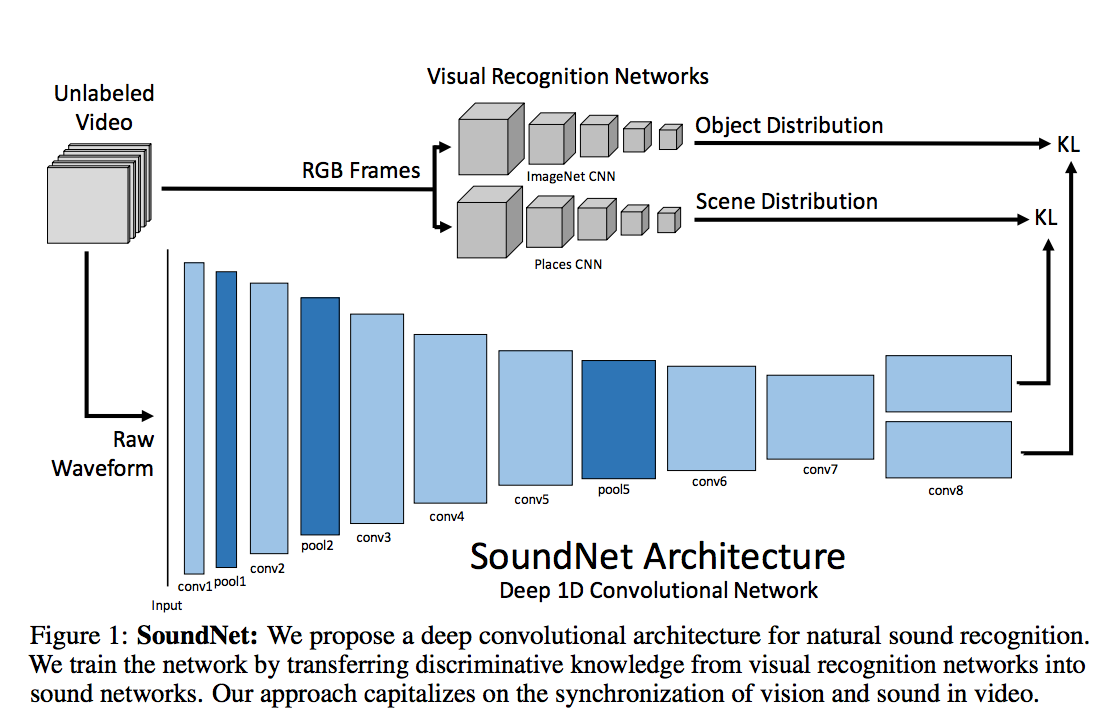

In [11]:
from IPython.display import Image
Image(filename='./1.png')

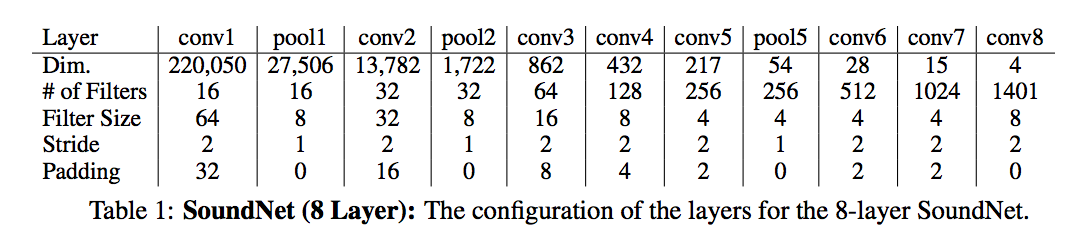

In [12]:
Image(filename='./2.png')

In [1]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.autograd import Variable
import torch.nn.functional as F

/Users/YumaKajihara/.pyenv/versions/anaconda2-2.5.0/lib/python2.7/site-packages/torch/distributed/__init__.py:11: UserWarning: 
                                    WARNING
torch.distributed is a highly experimental package. The API will change without
notice and we're can't guarantee full correctness and expected performance yet.
We'll announce it once it's ready.

  """)


In [2]:
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

In [3]:
class SoundNet(nn.Module):
    def __init__(self):
        super(SoundNet, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, 64, stride=2, padding=32)
        self.pool1 = nn.MaxPool1d(8, stride=1, padding=0)
        self.conv2 = nn.Conv1d(16, 32, 32, stride=2, padding=16)
        self.pool2 = nn.MaxPool1d(8, stride=1, padding=0)
        self.conv3 = nn.Conv1d(32, 64, 16, stride=2, padding=8)
        self.conv4 = nn.Conv1d(64, 128, 8, stride=2, padding=4)
        self.conv5 = nn.Conv1d(128, 256, 4, stride=2, padding=2)
        self.pool5 = nn.MaxPool1d(4, stride=1, padding=0)
        self.conv6 = nn.Conv1d(256, 512, 4, stride=2, padding=2)
        self.conv7 = nn.Conv1d(512, 1024, 4, stride=2, padding=2)
        self.conv8_1 = nn.Conv1d(1024, 1000, 4, stride=2, padding=0)
        self.conv8_2 = nn.Conv1d(1024, 401, 4, stride=2, padding=0)
        self.fc1 = nn.Linear(859000, 1000)
        self.fc2 = nn.Linear(344459, 365)
    
    
    def forward(self, input_wav):
        x = self.pool1(F.relu(nn.BatchNorm1d(16)(self.conv1(input_wav))))
        x = self.pool2(F.relu(nn.BatchNorm1d(32)(self.conv2(x))))
        x = F.relu(nn.BatchNorm1d(64)(self.conv3(x)))
        x = F.relu(nn.BatchNorm1d(128)(self.conv4(x)))
        x = self.pool5(F.relu(nn.BatchNorm1d(256)(self.conv5(x))))
        x = F.relu(nn.BatchNorm1d(512)(self.conv6(x)))
        x = F.relu(nn.BatchNorm1d(1024)(self.conv7(x)))
        x_object = Flatten()(F.relu(self.conv8_1(x)))
        x_place = Flatten()(F.relu(self.conv8_2(x)))
        x_object = self.fc1(x_object)
        x_place = self.fc2(x_place)
        y = [x_object, x_place]
        return y

In [4]:
net = SoundNet()

## Datasets

In [5]:
# Dummy
input_tensor = torch.rand(1000, 1, 220050)
target_tensor = torch.rand(1000, 1365)

In [6]:
train = torch.utils.data.TensorDataset(input_tensor, target_tensor)
train_loader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)

## Lossの書き方

In [9]:
optimizer = optim.Adam(net.parameters(), lr = 0.0001)
loss_fn = torch.nn.KLDivLoss()
for batch_idx, (input_tensor, target) in enumerate(train_loader):
    object_target, place_target = target[:, :1000], target[:, 1000:]
    input_tensor, object_target, place_target = Variable(input_tensor), Variable(object_target), Variable(place_target)
    optimizer.zero_grad()
    object_out, place_out = net(input_tensor)
    loss_o = loss_fn(object_out, object_target)
    loss_p = loss_fn(place_out, place_target)
    loss = loss_o + loss_p
    print "O_Loss , P_Loss, Total Loss ::: ", loss_o.data, loss_p.data, loss.data
    loss.backward()
    optimizer.step()
    print batch_idx, "finished!"

Variable containing:
-0.2486
[torch.FloatTensor of size 1]



KeyboardInterrupt: 